In [1]:
tracks={}
for no in ['A','B','C','D']:
    tracks[no] = pd.read_csv("dataset/track_" + no + ".csv",
                             usecols=['date', 'キロ程', '高低左'],
                             parse_dates=["date"])

In [2]:
%matplotlib inline

In [3]:
import datetime
from tqdm import tqdm
import random
import sys

In [4]:
def get_day(dates):
    day = [(date - datetime.datetime(2017, 4, 1)).days for date in dates]
    return np.array(day)

In [5]:
def feature_engineering(df, dmm, mv, admm):
    if dmm:
         df['diff_moving_mean'] = df['高低左'] - df['高低左'].rolling(window=7, min_periods=1, center=True).median()
    if mv:
        df['moving_variance'] = df['高低左'].rolling(window=7, min_periods=1, center=True).kurt()
    if admm:
        df['accumulation_diff_moving_mean'] = np.cumsum(
            abs(df['高低左'].rolling(window=3, min_periods=1, center=True).median() -
                df['高低左'].rolling(window=15, min_periods=1, center=False).median()))
    return df

In [6]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [7]:
def scaling(df, w1, w2, w3, w4):
    df['day'] = ss.fit_transform(df['day'].astype(float).values.reshape(len(df), 1))
    if w1 != 0:
        df['高低左'] = ss.fit_transform(df['高低左'].values.reshape(len(df), 1))*w1
    if w2 != 0:
        df['diff_moving_mean'] = ss.fit_transform(df['diff_moving_mean'].values.reshape(len(df), 1))*w2
    if w3 != 0:
        df['moving_variance'] = df['moving_variance'].fillna(0) #rollingした高低左が全部同じ値のときはNANになる
        df['moving_variance'] = ss.fit_transform(df['moving_variance'].values.reshape(len(df), 1))*w3
    if w4 != 0:
        df['accumulation_diff_moving_mean'] = \
        ss.fit_transform(df['accumulation_diff_moving_mean'].values.reshape(len(df), 1))*w4
    return df

In [8]:
from sklearn.neighbors import KernelDensity
bandwidth = [0.1, 1, 10, 50, 100]
kernel = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']
metric = ['minkowski', 'cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
leaf_size = [10, 40, 400, 4000]
kd = KernelDensity(bandwidth=bandwidth[3], kernel=kernel[0], metric=metric[0], leaf_size=leaf_size[1])

In [9]:
def kd_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.99999, False, True)].index.values
    return normal_id

In [10]:
def kd_outliers1(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.999, False, True)].index.values
    return normal_id

In [11]:
def kd_outliers2(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.99998, False, True)].index.values
    return normal_id

In [12]:
from scipy.cluster.hierarchy import linkage, fcluster

In [13]:
def dendrogram_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, True, False, True)
    df = scaling(df, 10, 50, 0, 100)

    linkage_result = linkage(df, method='ward', metric='euclidean')
    threshold = 0.95 * np.max(linkage_result[:, 2])
    clustered = fcluster(linkage_result, threshold, criterion='distance')

    df['label'] = clustered
    normal_label = df['label'].mode()[0]
    normal_id = df[df['label'] == normal_label].index.values
    return normal_id

In [14]:
def remove_outliers(raw):
    local_global = [[[], []], [[], []], [[], []], [[], []]]
    local_global[0][1].extend(raw.index.values)
    df1 = raw.copy()
    local_global[1][1].extend(kd_outliers(df1))

    df2 = raw.loc[local_global[1][1]]
    df2 = df2.reset_index(drop=True)
    local_global[2][0].extend(dendrogram_outliers(df2))
    local_global[2][1].extend([local_global[1][1][i] for i in local_global[2][0]])

    df3 = raw.loc[local_global[2][1]]
    df3 = df3.reset_index(drop=True)
    local_global[3][0].extend(kd_outliers2(df3))
    local_global[3][1].extend([local_global[2][1][i] for i in local_global[3][0]])
    return local_global[3][1]

def flag_outliers(raw):
    local_global = [[[], []], [[], []], [[], []], [[], []]]
    local_global[0][1].extend(raw.index.values)
    df1 = raw.copy()
    local_global[1][1].extend(kd_outliers(df1))

    df2 = raw.loc[local_global[1][1]]
    df2 = df2.reset_index(drop=True)
    local_global[2][0].extend(dendrogram_outliers(df2))
    local_global[2][1].extend([local_global[1][1][i] for i in local_global[2][0]])

    df3 = raw.loc[local_global[2][1]]
    df3 = df3.reset_index(drop=True)
    local_global[3][0].extend(kd_outliers2(df3))
    local_global[3][1].extend([local_global[2][1][i] for i in local_global[3][0]])

    out1 = set(local_global[0][1]) - set(local_global[1][1])
    out2 = set(local_global[1][1]) - set(local_global[2][1])
    out3 = set(local_global[2][1]) - set(local_global[3][1])
    normal = local_global[3][1]
    return out1, out2, out3, normal

fig, axes = plt.subplots(50, 1, figsize=(15, 100), sharex=True)
random.seed(110)
track = tracks['C']
kilos = track['キロ程'].unique()

for i, kilo in enumerate(random.sample(list(kilos), 50)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    if len(data) < 20:
        print(i)
        continue
    out1, out2, out3, normal = flag_outliers(data)

    datao1 = data.loc[out1]
    datao2 = data.loc[out2]
    datao3 = data.loc[out3]
    datal = data.loc[normal]

    axes[i].plot(datao1['day'], datao1['高低左'], marker='.', linewidth=0, c='c')
    axes[i].plot(datao2['day'], datao2['高低左'], marker='.', linewidth=0, c='g')
    axes[i].plot(datao3['day'], datao3['高低左'], marker='.', linewidth=0, c='r')
    axes[i].plot(datal['day'], datal['高低左'], marker='.', linewidth=0, c='b')

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [16]:
def get_slope_variance(X, y):
    if len(X) < 10:
        slope = 100
        variance = 100
    else:
        data = np.array([X, y]).T
        pca.fit(data)
        cmp = pca.components_
        cov = pca.get_covariance()

        slope = cmp[0, 1] / cmp[0, 0]
        variance = cov[1, 1] / cov[0, 0]

    return slope, variance

In [17]:
def get_intercept(raw):
    data = raw.copy()
    if sum(data['date'] >= "2018-03-01") == 0:
        print('sum(data["date"] >= "2018-03-01") == 0')
        intercept = np.median(data['高低左'].values[-10:])

    else:
        data = data.loc[data['date'] >= "2018-03-01"]
        data = data.reset_index(drop=True)
        data = data.drop('date', axis=1)
        if len(data) < 4:
            print('sum(data["date"] >= "2018-03-01") < 4')
            intercept = np.median(data['高低左'].values)

        else:
            normal_id = kd_outliers1(data)
            data = data.loc[normal_id]
            intercept = np.median(data['高低左'].values)

    return intercept

In [18]:
summarys12_left = {}
for no in ['A', 'B', 'C', 'D']:
    summarys12_left[no] = pd.read_csv(f'summary12_refine_{no}.csv', index_col=0)

In [57]:
summarys12_right = {}
for no in ['A', 'B', 'C', 'D']:
    summarys12_right[no] = pd.read_csv(f'summary12_right_{no}.csv', usecols=['傾き'])

In [64]:
summarys4_left = {}
for no in ['A', 'B', 'C', 'D']:
    summarys4_left[no] = pd.read_csv(f'summary4_refine_{no}.csv', usecols=['傾き'])

In [65]:
summarys4_right = {}
for no in ['A', 'B', 'C', 'D']:
    summarys4_right[no] = pd.read_csv(f'summary4_refine_right_{no}.csv', usecols=['傾き'])

In [72]:
summarys5_left = {}
for no in ['A', 'B', 'C', 'D']:
    summarys5_left[no] = pd.read_csv(f'summary5_refine_{no}.csv', usecols=['傾き'])

In [73]:
summarys5_right = {}
for no in ['A', 'B', 'C', 'D']:
    summarys5_right[no] = pd.read_csv(f'summary5_refine_right_{no}.csv', usecols=['傾き'])

In [24]:
for no in ['A', 'B', 'C', 'D']:
    summarys12_left[no].loc[summarys12_left[no]['傾き'] == 100, '傾き'] = \
    np.median(summarys12_left[no].loc[summarys12_left[no]['傾き'].notnull(), '傾き'])
    summarys12_left[no].loc[summarys12_left[no]['分散比'] == 100, '分散比'] = \
    np.median(summarys12_left[no].loc[summarys12_left[no]['分散比'].notnull(), '分散比'])
    summarys12_left[no].loc[summarys12_left[no]['傾き'].isnull(), '傾き'] = \
    np.median(summarys12_left[no].loc[summarys12_left[no]['傾き'].notnull(), '傾き'])
    summarys12_left[no].loc[summarys12_left[no]['切片'].isnull(), '切片'] = \
    np.median(summarys12_left[no].loc[summarys12_left[no]['切片'].notnull(), '切片'])

In [59]:
for no in ['A', 'B', 'C', 'D']:
    summarys12_right[no].loc[summarys12_right[no]['傾き'] == 100, '傾き'] = \
    np.median(summarys12_right[no].loc[summarys12_right[no]['傾き'].notnull(), '傾き'])
    summarys12_right[no].loc[summarys12_right[no]['傾き'].isnull(), '傾き'] = \
    np.median(summarys12_right[no].loc[summarys12_right[no]['傾き'].notnull(), '傾き'])

In [66]:
for no in ['A', 'B', 'C', 'D']:
    summarys4_left[no].loc[summarys4_left[no]['傾き'] == 100, '傾き'] = \
    np.median(summarys4_left[no].loc[summarys4_left[no]['傾き'].notnull(), '傾き'])
    summarys4_left[no].loc[summarys4_left[no]['傾き'].isnull(), '傾き'] = \
    np.median(summarys4_left[no].loc[summarys4_left[no]['傾き'].notnull(), '傾き'])

In [67]:
for no in ['A', 'B', 'C', 'D']:
    summarys4_right[no].loc[summarys4_right[no]['傾き'] == 100, '傾き'] = \
    np.median(summarys4_right[no].loc[summarys4_right[no]['傾き'].notnull(), '傾き'])
    summarys4_right[no].loc[summarys4_right[no]['傾き'].isnull(), '傾き'] = \
    np.median(summarys4_right[no].loc[summarys4_right[no]['傾き'].notnull(), '傾き'])

In [74]:
for no in ['A', 'B', 'C', 'D']:
    summarys5_left[no].loc[summarys5_left[no]['傾き'] == 100, '傾き'] = \
    np.median(summarys5_left[no].loc[summarys5_left[no]['傾き'].notnull(), '傾き'])
    summarys5_left[no].loc[summarys5_left[no]['傾き'].isnull(), '傾き'] = \
    np.median(summarys5_left[no].loc[summarys5_left[no]['傾き'].notnull(), '傾き'])

In [75]:
for no in ['A', 'B', 'C', 'D']:
    summarys5_right[no].loc[summarys5_right[no]['傾き'] == 100, '傾き'] = \
    np.median(summarys5_right[no].loc[summarys5_right[no]['傾き'].notnull(), '傾き'])
    summarys5_right[no].loc[summarys5_right[no]['傾き'].isnull(), '傾き'] = \
    np.median(summarys5_right[no].loc[summarys5_right[no]['傾き'].notnull(), '傾き'])

In [44]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor()

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [45]:
for no in ['A', 'B', 'C', 'D']:
    train = pd.DataFrame(summarys12_left[no]['傾き'].copy())
    for i in range(30):
        train[f'lag{i+1}'] = train['傾き'].shift(i+1)

    X_train = train.drop(['傾き'], axis=1).values
    y_train = train['傾き'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys12_left[no]['傾き_lgbm'] = train_pred

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [60]:
for no in ['A', 'B', 'C', 'D']:
    train = pd.DataFrame(summarys12_right[no]['傾き'].copy())
    for i in range(30):
        train[f'lag{i+1}'] = train['傾き'].shift(i+1)

    X_train = train.drop(['傾き'], axis=1).values
    y_train = train['傾き'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys12_right[no]['傾き_lgbm'] = train_pred

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [68]:
for no in ['A', 'B', 'C', 'D']:
    train = pd.DataFrame(summarys4_left[no]['傾き'].copy())
    for i in range(30):
        train[f'lag{i+1}'] = train['傾き'].shift(i+1)

    X_train = train.drop(['傾き'], axis=1).values
    y_train = train['傾き'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys4_left[no]['傾き_lgbm'] = train_pred

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [69]:
for no in ['A', 'B', 'C', 'D']:
    train = pd.DataFrame(summarys4_right[no]['傾き'].copy())
    for i in range(30):
        train[f'lag{i+1}'] = train['傾き'].shift(i+1)

    X_train = train.drop(['傾き'], axis=1).values
    y_train = train['傾き'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys4_right[no]['傾き_lgbm'] = train_pred

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [76]:
for no in ['A', 'B', 'C', 'D']:
    train = pd.DataFrame(summarys5_left[no]['傾き'].copy())
    for i in range(30):
        train[f'lag{i+1}'] = train['傾き'].shift(i+1)

    X_train = train.drop(['傾き'], axis=1).values
    y_train = train['傾き'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys5_left[no]['傾き_lgbm'] = train_pred

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [77]:
for no in ['A', 'B', 'C', 'D']:
    train = pd.DataFrame(summarys5_right[no]['傾き'].copy())
    for i in range(30):
        train[f'lag{i+1}'] = train['傾き'].shift(i+1)

    X_train = train.drop(['傾き'], axis=1).values
    y_train = train['傾き'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys5_right[no]['傾き_lgbm'] = train_pred

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [82]:
summarys = {}
for no in ['A', 'B', 'C', 'D']:
    summarys[no] = summarys12_left[no].drop(['分散比', '測定回数', 'データ数'], axis=1)
    summarys[no]['傾き12右'] = summarys12_right[no]['傾き']
    summarys[no]['傾き12右_lgbm'] = summarys12_right[no]['傾き_lgbm']
    summarys[no]['傾き4左'] = summarys4_left[no]['傾き']
    summarys[no]['傾き4左_lgbm'] = summarys4_left[no]['傾き_lgbm']
    summarys[no]['傾き4右'] = summarys4_right[no]['傾き']
    summarys[no]['傾き4右_lgbm'] = summarys4_right[no]['傾き_lgbm']
    summarys[no]['傾き5左'] = summarys5_left[no]['傾き']
    summarys[no]['傾き5左_lgbm'] = summarys5_left[no]['傾き_lgbm']
    summarys[no]['傾き5右'] = summarys5_right[no]['傾き']
    summarys[no]['傾き5右_lgbm'] = summarys5_right[no]['傾き_lgbm']

In [83]:
summarys['A']

,路線,キロ程,傾き,切片,傾き_lgbm,傾き12右,傾き12右_lgbm,傾き4左,傾き4左_lgbm,傾き4右,傾き4右_lgbm,傾き5左,傾き5左_lgbm,傾き5右,傾き5右_lgbm
0,A,10000,-0.003068,0.375,-0.002667,0.000899,0.000735,-0.002227,-0.001902,-0.000478,0.000016,-0.004349,-0.005217,0.000528,-0.000701
1,A,10001,-0.002222,2.680,-0.002633,0.000167,0.000860,-0.001725,-0.001831,0.000215,0.000435,-0.002332,-0.003880,-0.004745,-0.002868
2,A,10002,-0.003626,5.005,-0.002861,0.000166,0.000596,-0.002314,-0.002184,0.000483,0.000501,-0.009613,-0.006428,0.000105,0.000298
3,A,10003,0.000199,5.955,-0.000581,0.002050,0.001178,-0.002464,-0.001986,0.001061,0.000547,-0.000816,-0.002460,0.004835,0.002837
4,A,10004,0.002985,5.000,0.002258,0.002450,0.002056,-0.000732,-0.000564,0.001321,0.001634,0.002342,0.001434,0.002930,0.003851
5,A,10005,0.000586,1.645,0.001974,0.003076,0.003341,0.000105,0.000055,0.003380,0.002133,-0.004209,-0.003445,0.003121,0.003312
6,A,10006,-0.000215,-3.175,0.000671,0.005963,0.004592,0.002266,0.001514,0.007386,0.006269,-0.003520,-0.001528,0.003897,0.003723
7,A,10007,0.003765,-7.135,0.001227,0.003947,0.004555,0.002468,0.002492,0.004384,0.004272,0.007349,0.004144,0.007831,0.005339
8,A,10008,0.001148,-8.850,0.000996,0.002785,0.003207,0.001612,0.001308,0.000820,0.001256,0.001929,0.002280,0.001691,0.002349
9,A,10009,-0.001019,-7.410,-0.000751,-0.002543,-0.001384,-0.000989,0.000016,-0.002942,-0.002151,-0.001995,-0.001753,-0.003636,-0.001734


In [84]:
del summarys12_left, summarys12_right, summarys4_left, summarys4_right, summarys5_left, summarys5_right

In [102]:
from sklearn.metrics import mean_absolute_error

In [145]:
for no in tqdm(['A', 'B', 'C', 'D']):
    track = tracks[no]
    summary = summarys[no]
    summary['傾き_best'] = 0.
    kilos = summary['キロ程'].values[:10]
    for kilo in tqdm(kilos):
        data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
        data = data.dropna()
        data = data.reset_index(drop=True)
        data['day'] = get_day(data['date'])
        data = data.drop(['date'], axis=1)
        slopes = summary.loc[summary['キロ程'] == kilo]
        slopes = slopes.drop(['路線', 'キロ程', '切片'], axis=1).values[0]
        errors = np.zeros_like(slopes)
        for i in range(4):
            tmp = data.loc[data['day'] >= i*91]
            tmp = tmp.loc[tmp['day'] < (i+1)*91]
            tmp = tmp.reset_index(drop=True)
            if len(tmp) < 5:
                continue
            normal_id = kd_outliers1(tmp)
            tmp = tmp.loc[normal_id]
            intercept = np.median(tmp['高低左'].values)
            for j, slope in enumerate(slopes):
                errors[j] += mean_absolute_error(tmp['高低左'].values,
                                                 [intercept + (day-46-91*i)*slope for day in tmp['day'].values])
        summary.loc[summary['キロ程'] == kilo, '傾き_best'] = slopes[np.argmin(errors)]
    summary.to_csv(f'summary19_{no}.csv')



  0%|          | 0/4 [00:00<?, ?it/s]


  0%|          | 0/10 [00:00<?, ?it/s]


 20%|██        | 2/10 [00:00<00:00, 10.12it/s]


 30%|███       | 3/10 [00:00<00:00,  7.05it/s]


 40%|████      | 4/10 [00:00<00:01,  5.62it/s]


 50%|█████     | 5/10 [00:00<00:00,  5.85it/s]


 60%|██████    | 6/10 [00:01<00:00,  5.77it/s]


 70%|███████   | 7/10 [00:01<00:00,  5.87it/s]


 80%|████████  | 8/10 [00:01<00:00,  5.01it/s]


 90%|█████████ | 9/10 [00:01<00:00,  4.45it/s]


100%|██████████| 10/10 [00:01<00:00,  5.05it/s]




 25%|██▌       | 1/4 [00:02<00:08,  2.68s/it]


  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:00<00:01,  7.88it/s]


 20%|██        | 2/10 [00:00<00:01,  7.90it/s]


 30%|███       | 3/10 [00:00<00:00,  7.58it/s]


 40%|████      | 4/10 [00:00<00:00,  7.35it/s]


 50%|█████     | 5/10 [00:00<00:00,  7.09it/s]


 60%|██████    | 6/10 [00:00<00:00,  7.29it/s]


 70%|███████   | 7/10 [00:01<00:00,  5.33it/s]


 80%|████████  | 8/10 [00:01<00:00,  4.96

In [150]:
summarys['D']#.iloc[20260:20270]

,路線,キロ程,傾き,切片,傾き_lgbm,傾き12右,傾き12右_lgbm,傾き4左,傾き4左_lgbm,傾き4右,傾き4右_lgbm,傾き5左,傾き5左_lgbm,傾き5右,傾き5右_lgbm,傾き_best
0,D,10000,-0.001744,-0.670,-0.000041,0.000415,0.000161,-0.002123,-0.002027,-0.002626,-0.002615,-0.000095,0.000536,-0.003976,-0.002944,-0.001744
1,D,10001,0.003181,-0.450,0.003812,-0.003045,-0.002188,-0.000351,-0.000263,-0.001131,-0.001415,0.006745,0.004384,-0.001665,-0.001691,-0.000351
2,D,10002,0.002455,0.340,0.002705,-0.000977,-0.001357,0.000283,0.000129,-0.000406,0.000121,-0.002842,-0.002182,0.003762,0.001919,-0.000406
3,D,10003,0.001804,1.275,0.001715,0.002353,0.001434,0.000041,0.001165,0.002466,0.001608,0.004136,0.002201,0.002517,0.002607,0.000000
4,D,10004,0.003191,1.510,0.001611,0.005427,0.002692,0.003496,0.002312,0.001548,0.001488,0.002334,-0.000022,0.002976,0.003844,-0.000022
5,D,10005,-0.000062,0.730,-0.000750,-0.006259,-0.003116,0.002483,0.001260,0.002936,0.001731,-0.011369,-0.003780,0.005472,0.002877,-0.003116
6,D,10006,-0.001089,-0.400,0.000429,-0.004719,-0.003500,-0.001851,0.001506,0.000335,0.001504,0.009815,0.007024,0.001441,0.001292,-0.003500
7,D,10007,0.002328,-1.035,0.000933,0.000347,-0.001030,0.003731,-0.000161,-0.002147,0.000464,0.004441,0.003496,0.000587,0.000340,-0.002147
8,D,10008,0.000415,-0.315,-0.000327,-0.001121,-0.000854,-0.003553,-0.000399,-0.000602,0.000085,-0.001311,0.000529,-0.001250,0.000762,-0.001311
9,D,10009,-0.001870,1.695,-0.000545,-0.000383,-0.002659,-0.001614,-0.001398,-0.000182,0.000460,-0.003451,-0.000967,0.000554,-0.000624,0.000000


Text(0.5, 1.0, 'kilo: 10000')

Text(0.5, 1.0, 'kilo: 10001')

Text(0.5, 1.0, 'kilo: 10002')

Text(0.5, 1.0, 'kilo: 10003')

Text(0.5, 1.0, 'kilo: 10004')

Text(0.5, 1.0, 'kilo: 10005')

Text(0.5, 1.0, 'kilo: 10006')

Text(0.5, 1.0, 'kilo: 10007')

Text(0.5, 1.0, 'kilo: 10008')

Text(0.5, 1.0, 'kilo: 10009')

Text(0.5, 1.0, 'kilo: 10010')

Text(0.5, 1.0, 'kilo: 10011')

Text(0.5, 1.0, 'kilo: 10012')

Text(0.5, 1.0, 'kilo: 10013')

Text(0.5, 1.0, 'kilo: 10014')

Text(0.5, 1.0, 'kilo: 10015')

Text(0.5, 1.0, 'kilo: 10016')

Text(0.5, 1.0, 'kilo: 10017')

Text(0.5, 1.0, 'kilo: 10018')

Text(0.5, 1.0, 'kilo: 10019')

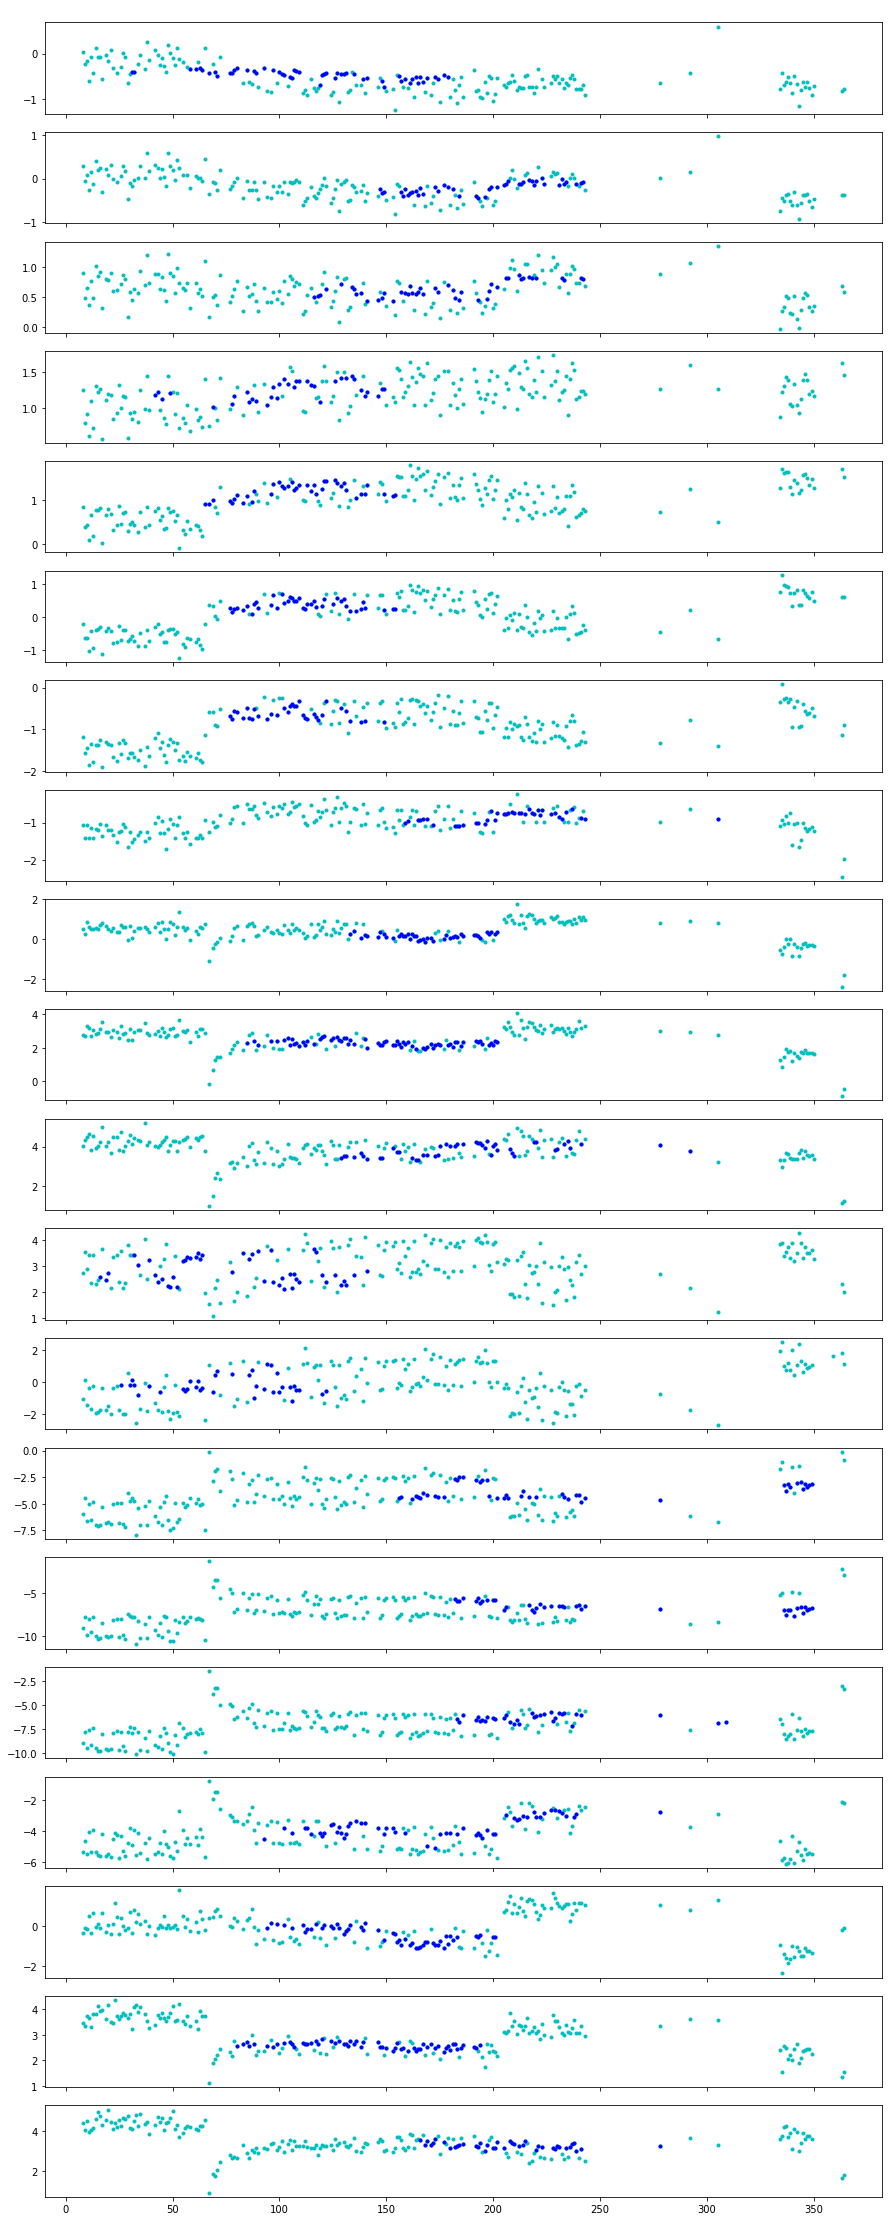

In [89]:
random.seed(10)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['D']
kilos = track['キロ程'].unique()[:20]
for i, kilo in enumerate(kilos):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo}', color='w')

In [110]:
summarys = {}
for no in ['A', 'B', 'C', 'D']:
    summarys[no] = pd.read_csv(f'summary19_{no}.csv', index_col=0)

In [111]:
p = []
intercept_day = 15
for no in ['A', 'B', 'C', 'D']:
    summary = summarys[no]
    for i in range(91):
        day = summary['切片'].values + summary['傾き_best'].values*(i+intercept_day)
        p.extend(day)

submision = pd.DataFrame(p)
print(sum(submision.isnull()))
submision = submision.fillna(0)
submision = submision.apply(lambda x:x.round(2)) #サイズが大きいため予測値を桁落とし

0


In [112]:
submision.max()

0    18.08
dtype: float64

In [113]:
submision.min()

0   -17.55
dtype: float64

submision.loc[submision[0] > 16, 0] = 16
submision.loc[submision[0] < -16, 0] = -16

In [114]:
len(submision[submision[0] >= 16])
len(submision[submision[0] <= -16])

344

552

In [115]:
submision

,0
0,0.39
1,2.68
2,5.01
3,5.96
4,5.03
5,1.65
6,-3.18
7,-7.12
8,-8.84
9,-7.42


In [116]:
submision.to_csv("submit19.csv", header=None)

Text(0.5, 1.0, 'kilo: 28723,  kilo_id: 18723')

Text(0.5, 1.0, 'kilo: 11067,  kilo_id: 1067')

Text(0.5, 1.0, 'kilo: 24053,  kilo_id: 14053')

Text(0.5, 1.0, 'kilo: 25812,  kilo_id: 15812')

Text(0.5, 1.0, 'kilo: 28942,  kilo_id: 18942')

Text(0.5, 1.0, 'kilo: 10486,  kilo_id: 486')

Text(0.5, 1.0, 'kilo: 16753,  kilo_id: 6753')

Text(0.5, 1.0, 'kilo: 25157,  kilo_id: 15157')

Text(0.5, 1.0, 'kilo: 36650,  kilo_id: 26650')

Text(0.5, 1.0, 'kilo: 26098,  kilo_id: 16098')

Text(0.5, 1.0, 'kilo: 36987,  kilo_id: 26987')

Text(0.5, 1.0, 'kilo: 19093,  kilo_id: 9093')

Text(0.5, 1.0, 'kilo: 31412,  kilo_id: 21412')

Text(0.5, 1.0, 'kilo: 36562,  kilo_id: 26562')

Text(0.5, 1.0, 'kilo: 15250,  kilo_id: 5250')

Text(0.5, 1.0, 'kilo: 11127,  kilo_id: 1127')

Text(0.5, 1.0, 'kilo: 27061,  kilo_id: 17061')

Text(0.5, 1.0, 'kilo: 26059,  kilo_id: 16059')

Text(0.5, 1.0, 'kilo: 20740,  kilo_id: 10740')

Text(0.5, 1.0, 'kilo: 12493,  kilo_id: 2493')

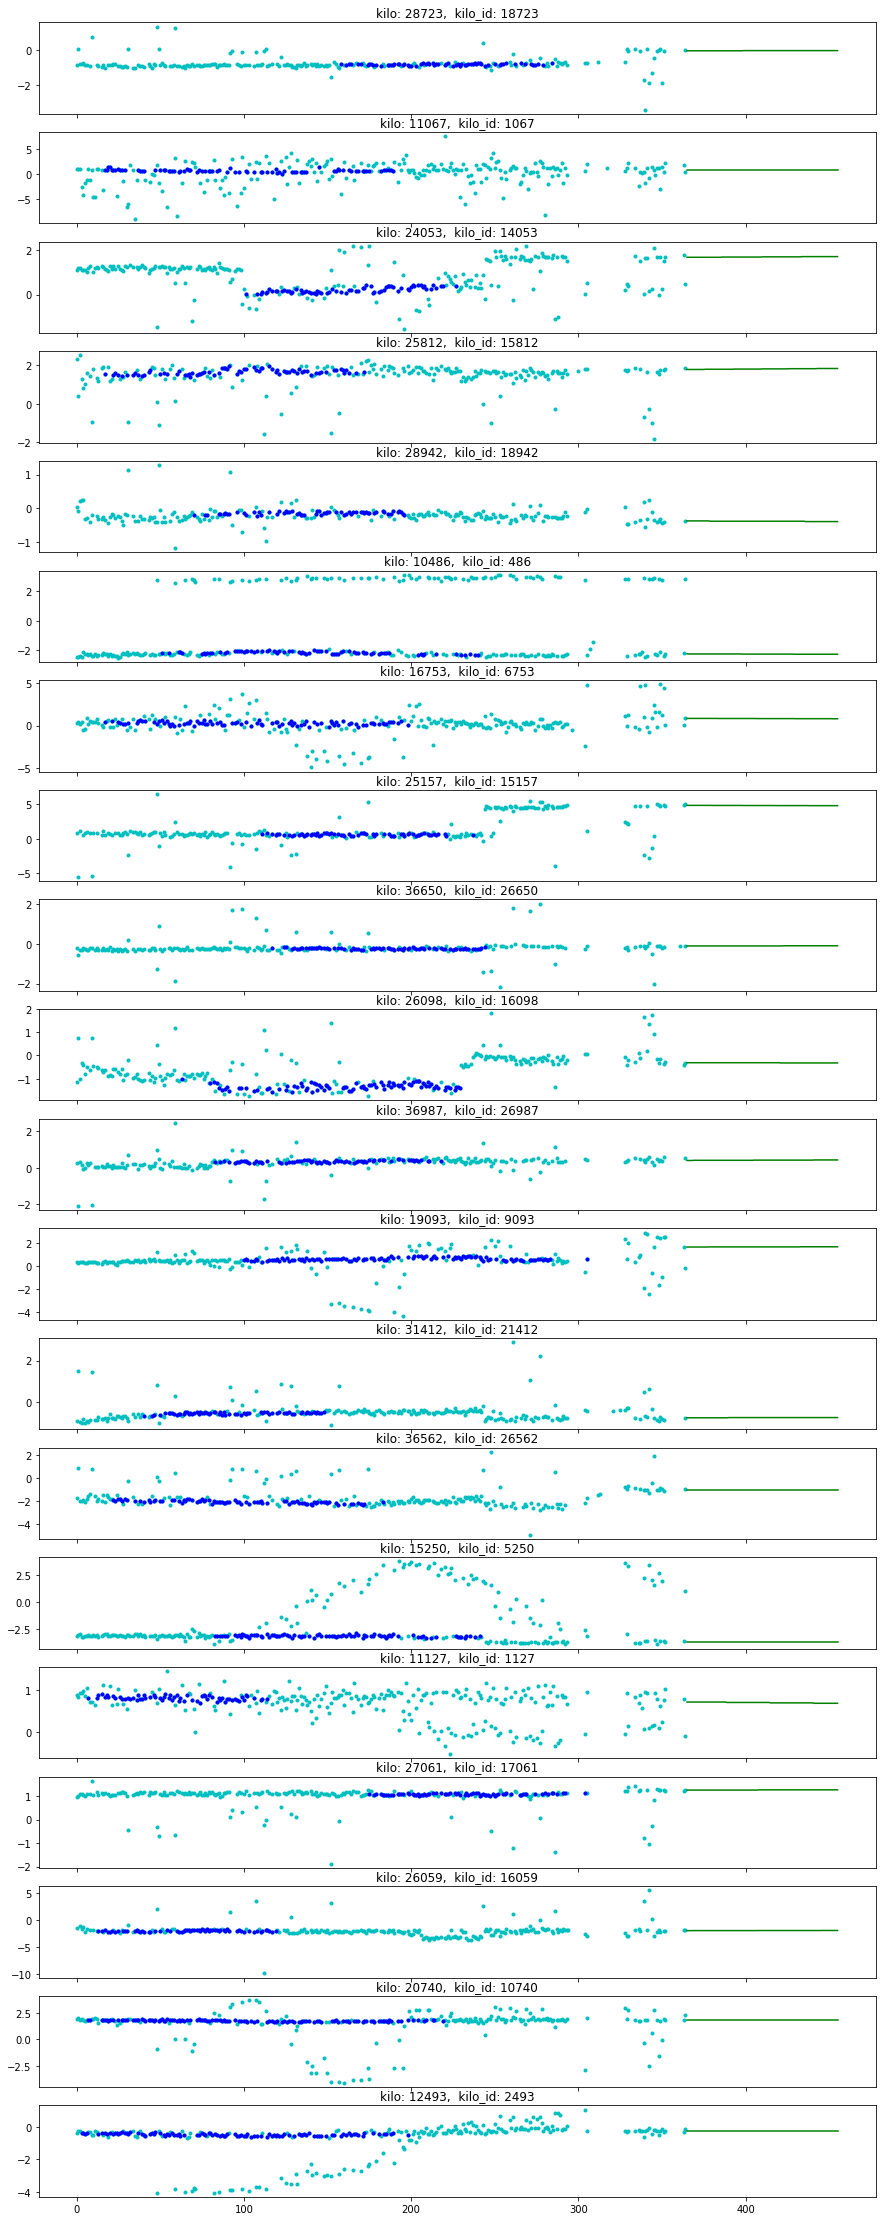

In [117]:
random.seed(10)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['A']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 22623,  kilo_id: 12623')

Text(0.5, 1.0, 'kilo: 23781,  kilo_id: 13781')

Text(0.5, 1.0, 'kilo: 11326,  kilo_id: 1326')

Text(0.5, 1.0, 'kilo: 18484,  kilo_id: 8484')

Text(0.5, 1.0, 'kilo: 26753,  kilo_id: 16753')

Text(0.5, 1.0, 'kilo: 25922,  kilo_id: 15922')

Text(0.5, 1.0, 'kilo: 23268,  kilo_id: 13268')

Text(0.5, 1.0, 'kilo: 19938,  kilo_id: 9938')

Text(0.5, 1.0, 'kilo: 25617,  kilo_id: 15617')

Text(0.5, 1.0, 'kilo: 21732,  kilo_id: 11732')

Text(0.5, 1.0, 'kilo: 29116,  kilo_id: 19116')

Text(0.5, 1.0, 'kilo: 17157,  kilo_id: 7157')

Text(0.5, 1.0, 'kilo: 26537,  kilo_id: 16537')

Text(0.5, 1.0, 'kilo: 14563,  kilo_id: 4563')

Text(0.5, 1.0, 'kilo: 19235,  kilo_id: 9235')

Text(0.5, 1.0, 'kilo: 14579,  kilo_id: 4579')

Text(0.5, 1.0, 'kilo: 13107,  kilo_id: 3107')

Text(0.5, 1.0, 'kilo: 30262,  kilo_id: 20262')

Text(0.5, 1.0, 'kilo: 18208,  kilo_id: 8208')

Text(0.5, 1.0, 'kilo: 27451,  kilo_id: 17451')

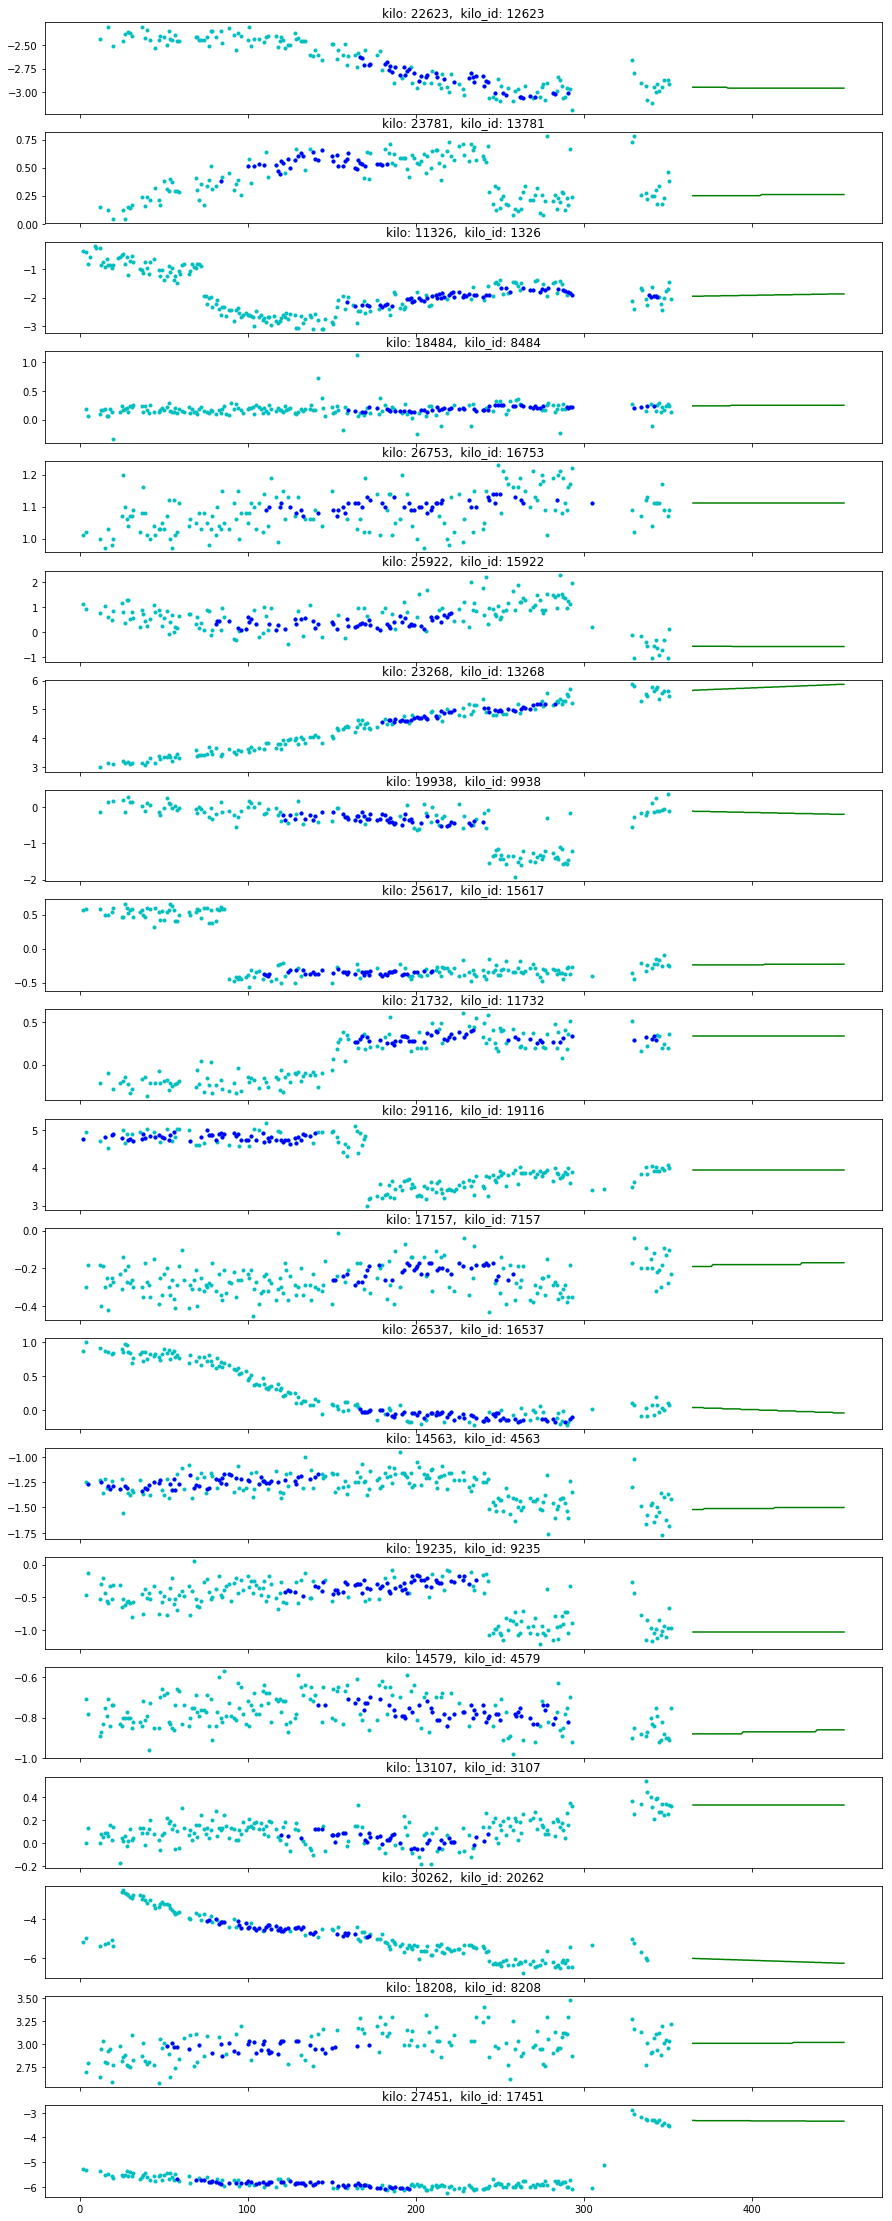

In [118]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['B']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 65340,  kilo_id: 55340')

Text(0.5, 1.0, 'kilo: 35247,  kilo_id: 25247')

Text(0.5, 1.0, 'kilo: 59673,  kilo_id: 49673')

Text(0.5, 1.0, 'kilo: 37562,  kilo_id: 27562')

Text(0.5, 1.0, 'kilo: 12653,  kilo_id: 2653')

Text(0.5, 1.0, 'kilo: 26968,  kilo_id: 16968')

Text(0.5, 1.0, 'kilo: 43506,  kilo_id: 33506')

Text(0.5, 1.0, 'kilo: 41845,  kilo_id: 31845')

Text(0.5, 1.0, 'kilo: 36537,  kilo_id: 26537')

Text(0.5, 1.0, 'kilo: 61367,  kilo_id: 51367')

Text(0.5, 1.0, 'kilo: 64385,  kilo_id: 54385')

Text(0.5, 1.0, 'kilo: 29877,  kilo_id: 19877')

Text(0.5, 1.0, 'kilo: 41234,  kilo_id: 31234')

Text(0.5, 1.0, 'kilo: 33465,  kilo_id: 23465')

Text(0.5, 1.0, 'kilo: 48232,  kilo_id: 38232')

Text(0.5, 1.0, 'kilo: 24315,  kilo_id: 14315')

Text(0.5, 1.0, 'kilo: 43075,  kilo_id: 33075')

Text(0.5, 1.0, 'kilo: 19127,  kilo_id: 9127')

Text(0.5, 1.0, 'kilo: 28470,  kilo_id: 18470')

Text(0.5, 1.0, 'kilo: 19158,  kilo_id: 9158')

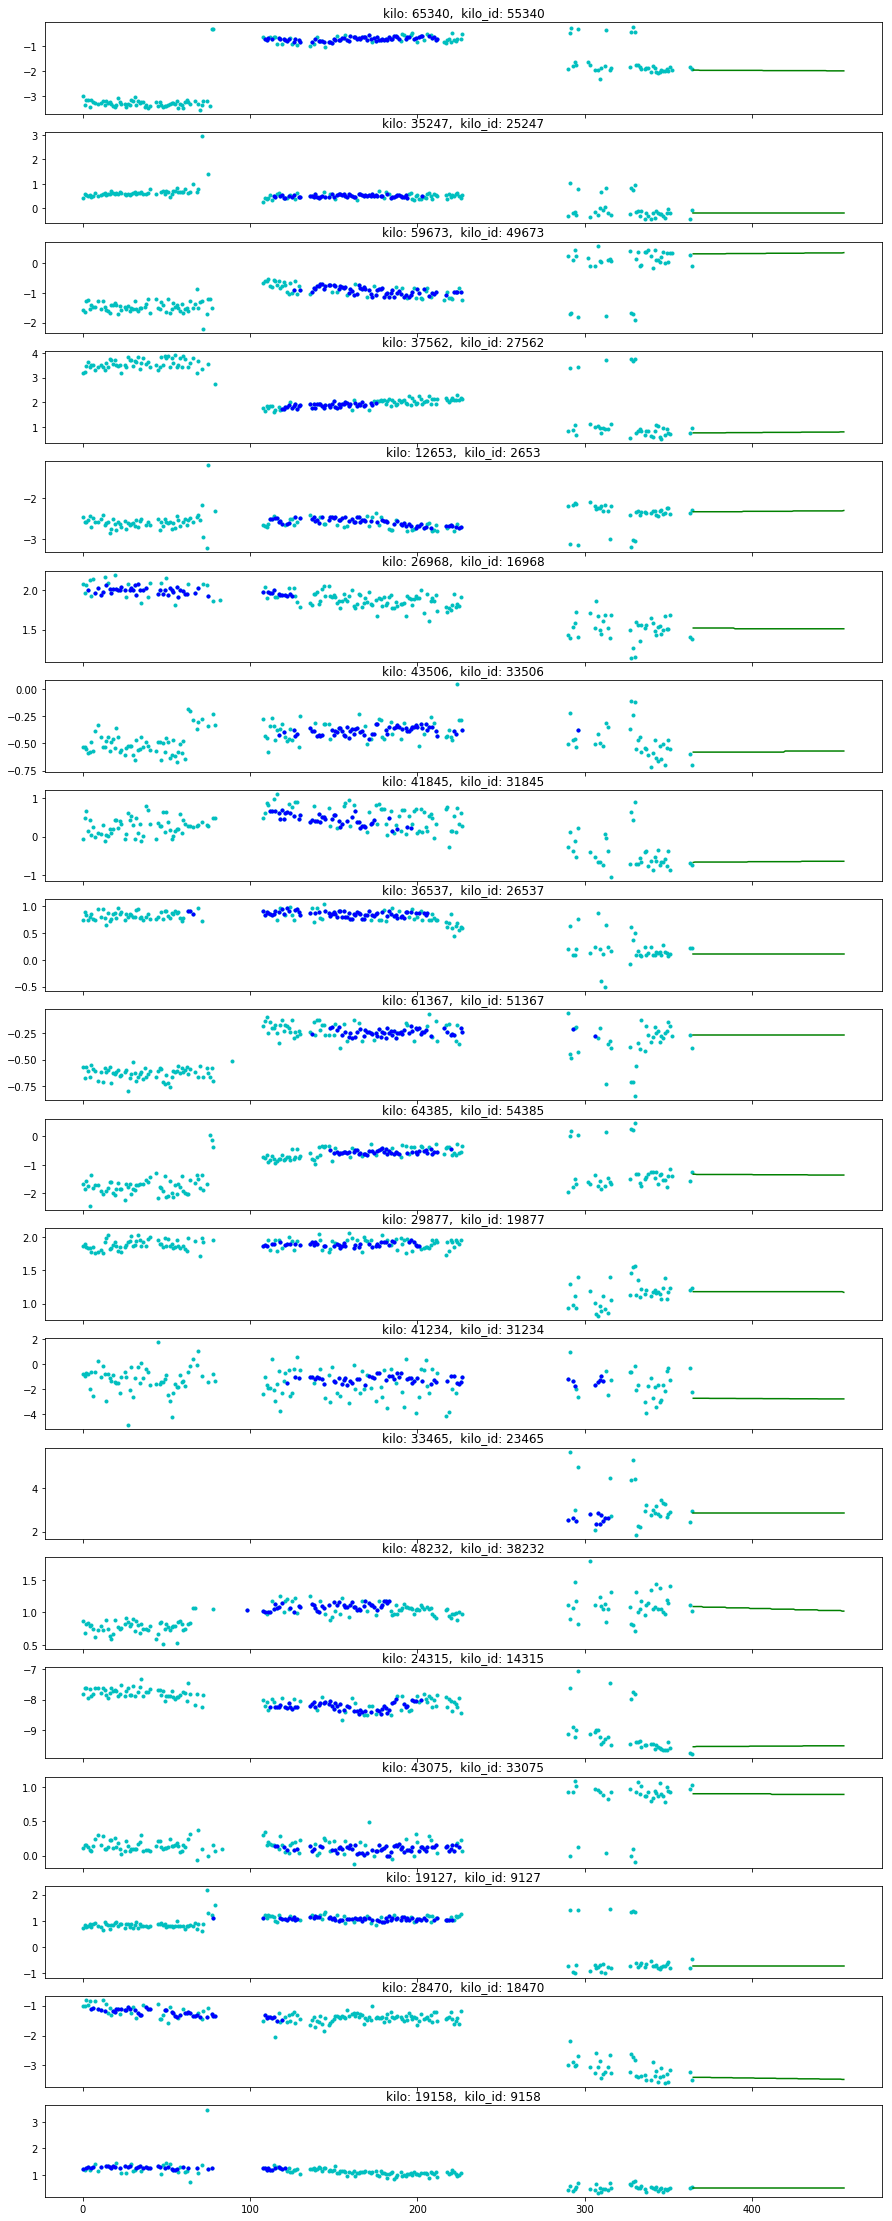

In [108]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['C']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91 + len(tracks['B']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 23835,  kilo_id: 13835')

Text(0.5, 1.0, 'kilo: 16311,  kilo_id: 6311')

Text(0.5, 1.0, 'kilo: 22418,  kilo_id: 12418')

Text(0.5, 1.0, 'kilo: 24585,  kilo_id: 14585')

Text(0.5, 1.0, 'kilo: 16890,  kilo_id: 6890')

Text(0.5, 1.0, 'kilo: 10663,  kilo_id: 663')

Text(0.5, 1.0, 'kilo: 14242,  kilo_id: 4242')

Text(0.5, 1.0, 'kilo: 18376,  kilo_id: 8376')

Text(0.5, 1.0, 'kilo: 17961,  kilo_id: 7961')

Text(0.5, 1.0, 'kilo: 16634,  kilo_id: 6634')

Text(0.5, 1.0, 'kilo: 25044,  kilo_id: 15044')

Text(0.5, 1.0, 'kilo: 22841,  kilo_id: 12841')

Text(0.5, 1.0, 'kilo: 23596,  kilo_id: 13596')

Text(0.5, 1.0, 'kilo: 14969,  kilo_id: 4969')

Text(0.5, 1.0, 'kilo: 17808,  kilo_id: 7808')

Text(0.5, 1.0, 'kilo: 15866,  kilo_id: 5866')

Text(0.5, 1.0, 'kilo: 19558,  kilo_id: 9558')

Text(0.5, 1.0, 'kilo: 24608,  kilo_id: 14608')

Text(0.5, 1.0, 'kilo: 24878,  kilo_id: 14878')

Text(0.5, 1.0, 'kilo: 13578,  kilo_id: 3578')

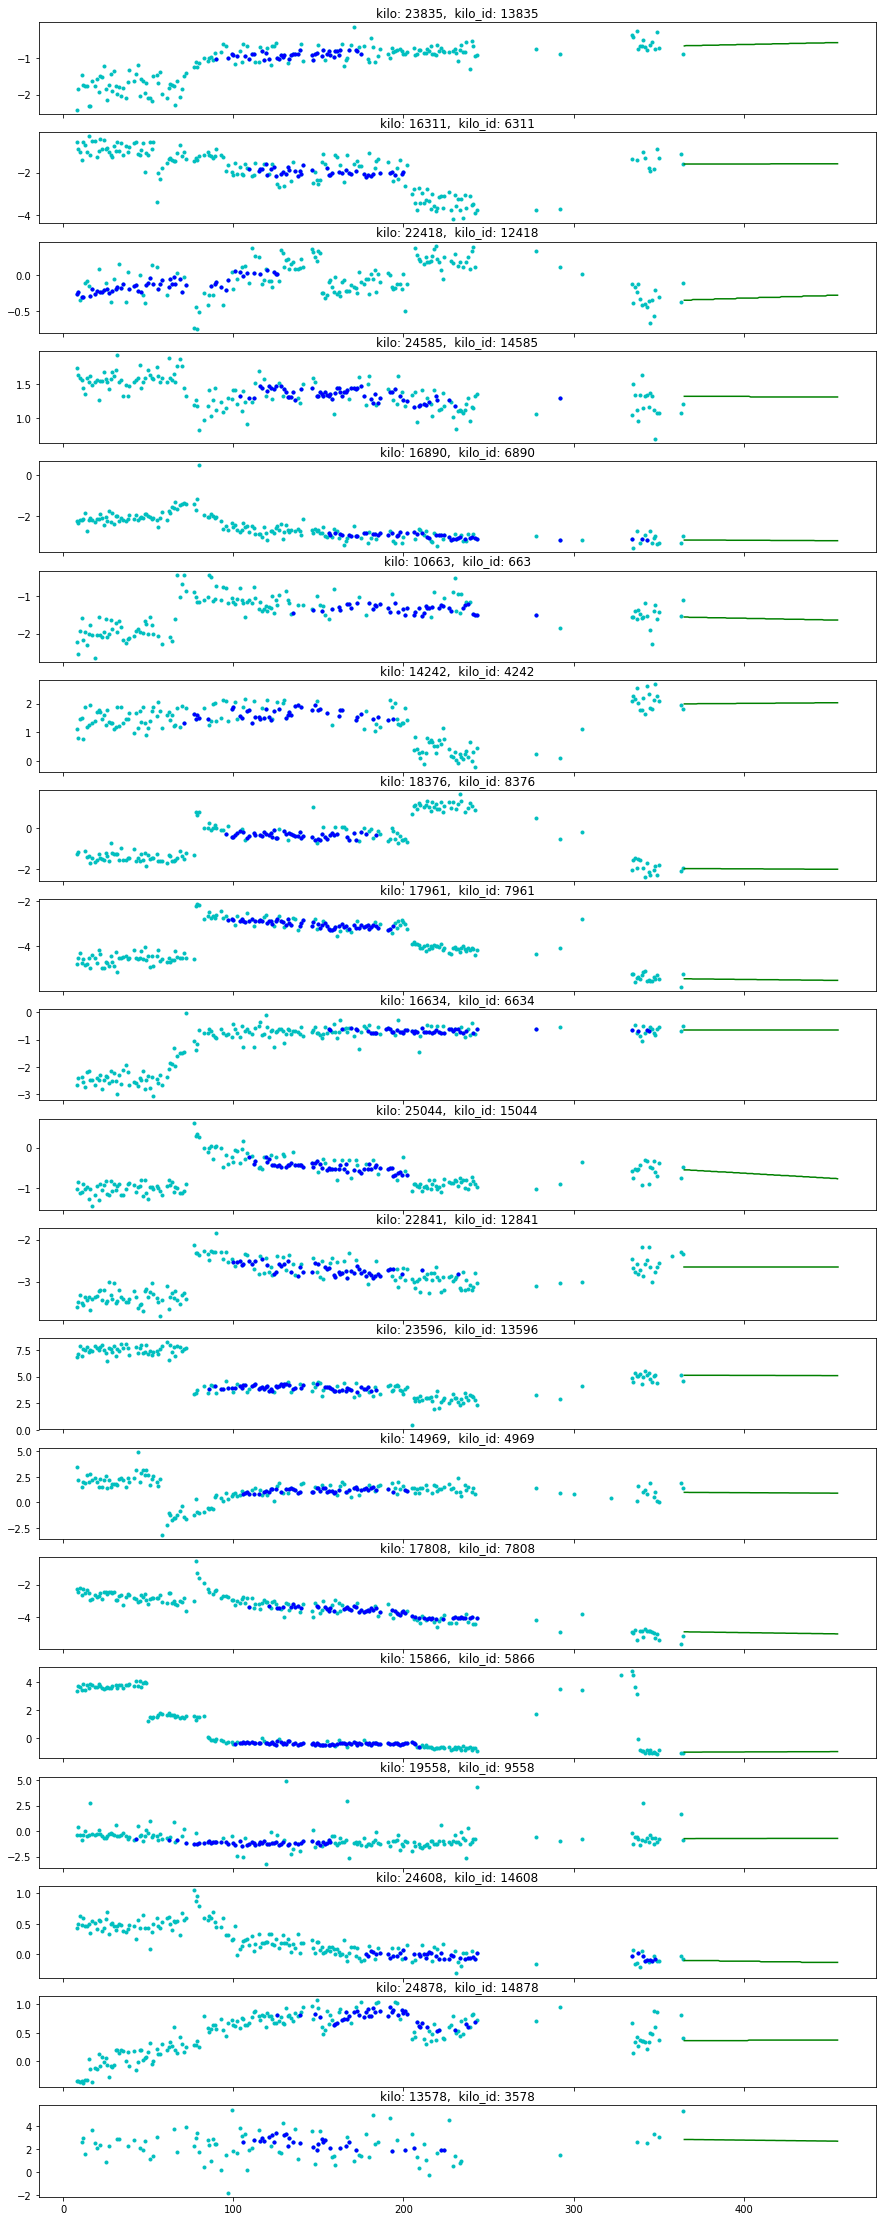

In [109]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['D']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91 + len(tracks['B']['キロ程'].unique())*91 + len(tracks['C']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

In [31]:
summarys = {}
for no in ['A', 'B', 'C', 'D']:
    summarys[no] = pd.read_csv(f'summary19_{no}.csv', index_col=0)

In [32]:
%%time
submit = pd.DataFrame()
for no in ['A', 'B', 'C', 'D']:
    summary = summarys[no]
    submit = pd.concat([submit, summary], axis=0)
submit = submit.reset_index(drop=True)

CPU times: user 92.9 ms, sys: 28.3 ms, total: 121 ms
Wall time: 63.5 ms


In [33]:
low = submit.sort_values('傾き_best').head(10)
high = submit.sort_values('傾き_best', ascending=False).head(10)
out_df = pd.concat([low, high], axis=0)
out_df

,路線,キロ程,傾き,切片,傾き_lgbm,傾き12右,傾き12右_lgbm,傾き4左,傾き4左_lgbm,傾き4右,傾き4右_lgbm,傾き5左,傾き5左_lgbm,傾き5右,傾き5右_lgbm,傾き_best
112300,D,17179,-0.028919,-11.225,-0.022449,-0.024396,-0.015840,-0.034010,-0.022839,-0.021814,-0.019899,-0.033898,-0.018419,-0.022315,-0.010624,-0.028919
16070,A,26070,-0.042736,-8.640,-0.035953,-0.028550,-0.023945,-0.035823,-0.026184,-0.012436,-0.005976,-0.035697,-0.024406,-0.021085,-0.009866,-0.028550
114344,D,19223,-0.071660,4.040,-0.027045,-0.025663,-0.012095,0.003944,0.002786,0.006868,0.002646,0.005639,0.003167,0.007787,0.004922,-0.027045
105348,D,10227,-0.003928,-9.950,-0.004445,0.004931,-0.002298,-0.003248,-0.009688,0.005543,-0.003108,-0.027765,-0.025024,-0.007015,-0.010224,-0.025024
115970,D,20849,-0.041435,-3.930,-0.034398,-0.019007,-0.014189,-0.041853,-0.032992,-0.015828,-0.012697,-0.035659,-0.024561,-0.010238,-0.010516,-0.024561
107369,D,12248,-0.036307,-6.040,-0.026013,-0.036824,-0.031568,-0.038112,-0.024435,-0.035097,-0.028225,0.001078,-0.004587,-0.036879,-0.015559,-0.024435
100015,C,60578,0.006701,-5.110,-0.000813,0.006218,0.003969,0.004106,0.002804,0.002688,0.003852,-0.040763,-0.034079,-0.033291,-0.022668,-0.022668
112301,D,17180,-0.025171,-15.790,-0.022309,-0.016207,-0.015274,-0.028388,-0.027096,-0.018098,-0.015940,-0.009162,-0.014349,-0.016953,-0.015639,-0.022309
29497,B,11591,-0.055751,-4.980,-0.033199,-0.030719,-0.021946,0.000066,-0.004546,0.000055,0.001078,0.000093,0.000768,0.000095,0.000105,-0.021946
114393,D,19272,0.008089,1.090,0.007709,0.011280,0.003707,0.006754,0.001840,0.007707,0.002327,-0.029835,-0.021891,0.012229,0.005775,-0.021891


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Text(0.5, 1.0, 'no: D,  kilo: 17179,  slope: -0.02891933142123425')

Text(0.5, 1.0, 'no: A,  kilo: 26070,  slope: -0.028549909588343508')

Text(0.5, 1.0, 'no: D,  kilo: 19223,  slope: -0.02704473481716413')

Text(0.5, 1.0, 'no: D,  kilo: 10227,  slope: -0.025024266371220117')

Text(0.5, 1.0, 'no: D,  kilo: 20849,  slope: -0.02456146736779492')

Text(0.5, 1.0, 'no: D,  kilo: 12248,  slope: -0.02443489310653768')

Text(0.5, 1.0, 'no: C,  kilo: 60578,  slope: -0.022667982964545717')

Text(0.5, 1.0, 'no: D,  kilo: 17180,  slope: -0.022309146950175048')

Text(0.5, 1.0, 'no: B,  kilo: 11591,  slope: -0.021946049340851915')

Text(0.5, 1.0, 'no: D,  kilo: 19272,  slope: -0.021891376800152348')

Text(0.5, 1.0, 'no: C,  kilo: 62389,  slope: 0.05465624733839327')

Text(0.5, 1.0, 'no: D,  kilo: 19216,  slope: 0.040783969979487036')

Text(0.5, 1.0, 'no: D,  kilo: 19244,  slope: 0.033990984586526087')

Text(0.5, 1.0, 'no: A,  kilo: 24639,  slope: 0.033604593139306436')

Text(0.5, 1.0, 'no: A,  kilo: 28132,  slope: 0.030613228108826523')

Text(0.5, 1.0, 'no: D,  kilo: 19243,  slope: 0.024646135510880397')

Text(0.5, 1.0, 'no: D,  kilo: 19202,  slope: 0.023297963064482')

Text(0.5, 1.0, 'no: C,  kilo: 64092,  slope: 0.022641784306471')

Text(0.5, 1.0, 'no: C,  kilo: 33477,  slope: 0.021242196499953347')

Text(0.5, 1.0, 'no: C,  kilo: 33418,  slope: 0.02012572460294981')

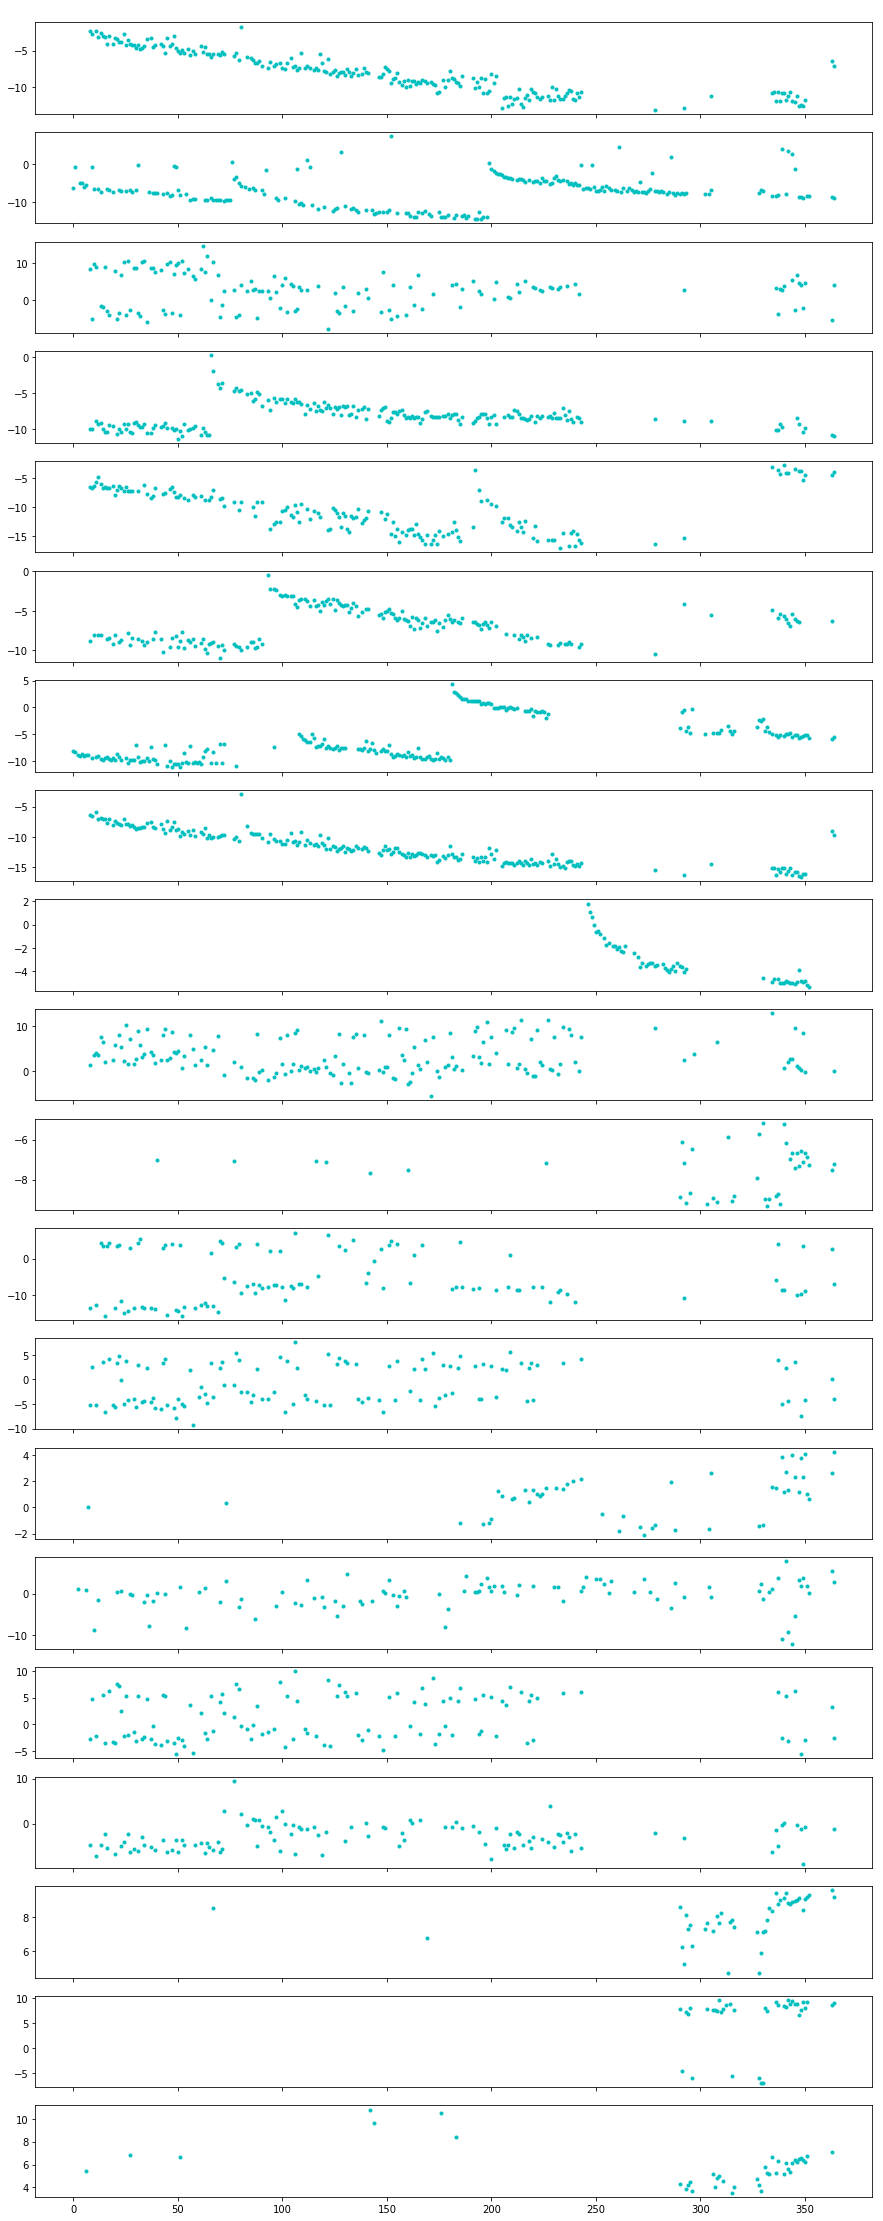

In [34]:
fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

for i, (no, kilo) in enumerate(zip(out_df['路線'], out_df['キロ程'])):
    track = tracks[no]
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左', '高低右', '水準']]
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    axes[i].set_title(f'no: {no},  kilo: {kilo},  slope: {out_df.iloc[i, -1]}', color='w')

In [35]:
submit

,路線,キロ程,傾き,切片,傾き_lgbm,傾き12右,傾き12右_lgbm,傾き4左,傾き4左_lgbm,傾き4右,傾き4右_lgbm,傾き5左,傾き5左_lgbm,傾き5右,傾き5右_lgbm,傾き_best
0,A,10000,-0.003068,0.375,-0.002667,0.000899,0.000735,-0.002227,-0.001902,-0.000478,0.000016,-0.004349,-0.005217,0.000528,-0.000701,-0.001902
1,A,10001,-0.002222,2.680,-0.002633,0.000167,0.000860,-0.001725,-0.001831,0.000215,0.000435,-0.002332,-0.003880,-0.004745,-0.002868,-0.002868
2,A,10002,-0.003626,5.005,-0.002861,0.000166,0.000596,-0.002314,-0.002184,0.000483,0.000501,-0.009613,-0.006428,0.000105,0.000298,0.000000
3,A,10003,0.000199,5.955,-0.000581,0.002050,0.001178,-0.002464,-0.001986,0.001061,0.000547,-0.000816,-0.002460,0.004835,0.002837,0.004835
4,A,10004,0.002985,5.000,0.002258,0.002450,0.002056,-0.000732,-0.000564,0.001321,0.001634,0.002342,0.001434,0.002930,0.003851,0.003851
5,A,10005,0.000586,1.645,0.001974,0.003076,0.003341,0.000105,0.000055,0.003380,0.002133,-0.004209,-0.003445,0.003121,0.003312,-0.003445
6,A,10006,-0.000215,-3.175,0.000671,0.005963,0.004592,0.002266,0.001514,0.007386,0.006269,-0.003520,-0.001528,0.003897,0.003723,0.001514
7,A,10007,0.003765,-7.135,0.001227,0.003947,0.004555,0.002468,0.002492,0.004384,0.004272,0.007349,0.004144,0.007831,0.005339,0.002492
8,A,10008,0.001148,-8.850,0.000996,0.002785,0.003207,0.001612,0.001308,0.000820,0.001256,0.001929,0.002280,0.001691,0.002349,0.000820
9,A,10009,-0.001019,-7.410,-0.000751,-0.002543,-0.001384,-0.000989,0.000016,-0.002942,-0.002151,-0.001995,-0.001753,-0.003636,-0.001734,0.000016


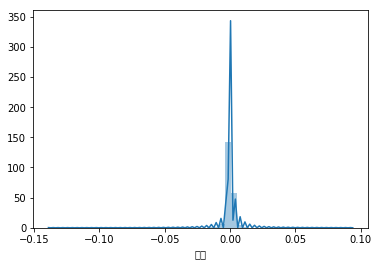

In [36]:
sns.distplot(submit['傾き'])

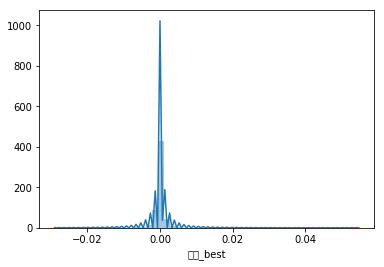

In [37]:
sns.distplot(submit['傾き_best'])

In [38]:
sum(submit['傾き_best'] == 0)

36114

In [40]:
submit[submit['傾き_best'] == 0]

,路線,キロ程,傾き,切片,傾き_lgbm,傾き12右,傾き12右_lgbm,傾き4左,傾き4左_lgbm,傾き4右,傾き4右_lgbm,傾き5左,傾き5左_lgbm,傾き5右,傾き5右_lgbm,傾き_best
2,A,10002,-0.003626,5.005,-0.002861,0.000166,0.000596,-0.002314,-0.002184,0.000483,0.000501,-0.009613,-0.006428,0.000105,0.000298,0.0
10,A,10010,-0.003736,-3.340,-0.002648,-0.002285,-0.003687,-0.002730,-0.002020,-0.003333,-0.004673,-0.000408,-0.000926,-0.004918,-0.004781,0.0
11,A,10011,-0.005004,1.150,-0.004538,-0.007490,-0.005048,-0.000060,-0.002301,-0.006679,-0.004483,-0.002553,-0.002611,-0.006615,-0.005992,0.0
12,A,10012,-0.004228,4.600,-0.003529,-0.005280,-0.006727,-0.003910,-0.001664,-0.004875,-0.005231,-0.004059,-0.003929,-0.005736,-0.005829,0.0
13,A,10013,-0.002615,5.460,-0.002398,-0.003589,-0.002760,-0.000791,-0.001695,-0.002468,-0.002120,-0.006956,-0.006045,-0.000374,-0.001242,0.0
21,A,10021,0.000628,-0.310,-0.001163,-0.000783,-0.001162,-0.000705,-0.001010,-0.000516,-0.000695,-0.001819,-0.000861,-0.001257,-0.000401,0.0
28,A,10028,0.002519,1.920,0.001492,0.003055,0.000976,0.003125,0.002150,0.003871,0.001945,0.003187,0.001062,0.004280,0.001096,0.0
32,A,10032,0.000158,-5.850,0.001557,0.013060,0.003811,0.000014,0.001440,0.000271,0.002452,0.000564,0.001145,0.001677,0.001322,0.0
37,A,10037,-0.000329,2.710,-0.001541,-0.000854,-0.003532,-0.000303,-0.001070,-0.001225,-0.001051,-0.003860,-0.000910,-0.001246,-0.002011,0.0
44,A,10044,-0.001577,3.980,-0.000406,-0.000270,-0.000148,0.004345,-0.001354,-0.000609,-0.000644,-0.001398,-0.000740,-0.000445,-0.000958,0.0


In [41]:
low = submit.sort_values('切片').head(10)
high = submit.sort_values('切片', ascending=False).head(10)
inter_df = pd.concat([low, high], axis=0)
inter_df

,路線,キロ程,傾き,切片,傾き_lgbm,傾き12右,傾き12右_lgbm,傾き4左,傾き4左_lgbm,傾き4右,傾き4右_lgbm,傾き5左,傾き5左_lgbm,傾き5右,傾き5右_lgbm,傾き_best
70976,C,31539,-0.005009,-17.320,-0.002238,-0.012113,-0.007406,-0.005874,-0.001996,-0.010705,-0.005848,-0.004993,-0.000476,-0.018634,-0.013400,-0.013400
29539,B,11633,0.000062,-16.705,0.000367,0.000057,-0.000204,0.000066,0.000149,0.000055,-0.000073,0.000093,0.000251,0.000095,0.000272,0.000367
36819,B,18913,0.000062,-16.185,0.000058,0.000057,0.000037,0.000066,0.000050,0.000055,0.000069,0.000093,0.000100,0.000095,0.000058,0.000062
108839,D,13718,-0.001364,-16.160,-0.002121,0.000385,-0.002025,0.000051,-0.001994,0.000069,-0.002281,0.001199,0.000288,-0.000184,0.001413,0.001199
29538,B,11632,0.000062,-16.020,0.000209,0.000057,-0.000218,0.000066,-0.000029,0.000055,0.000149,0.000093,0.000297,0.000095,-0.000142,0.000297
112301,D,17180,-0.025171,-15.790,-0.022309,-0.016207,-0.015274,-0.028388,-0.027096,-0.018098,-0.015940,-0.009162,-0.014349,-0.016953,-0.015639,-0.022309
86057,C,46620,-0.001099,-15.710,-0.002898,0.000788,-0.001927,-0.008298,-0.003604,-0.005196,-0.002762,-0.007978,-0.002055,-0.003637,-0.002133,-0.002133
109652,D,14531,-0.008357,-15.270,-0.003829,-0.005198,-0.003331,-0.004381,-0.001297,-0.007775,-0.003679,-0.009243,-0.001615,-0.004842,-0.002893,-0.009243
111493,D,16372,-0.017787,-15.260,-0.007728,-0.006151,-0.006839,-0.017348,-0.019645,-0.007734,-0.005511,-0.014400,-0.007111,-0.005192,-0.004112,-0.006151
36870,B,18964,0.000062,-15.150,-0.000598,0.000057,-0.000364,0.000066,0.001042,0.000055,-0.000261,0.000093,0.000215,0.000095,-0.000232,0.000062


Text(0.5, 1.0, 'no: C,  kilo: 31539,  intercept: -17.32')

Text(0.5, 1.0, 'no: B,  kilo: 11633,  intercept: -16.705')

Text(0.5, 1.0, 'no: B,  kilo: 18913,  intercept: -16.185')

Text(0.5, 1.0, 'no: D,  kilo: 13718,  intercept: -16.16')

Text(0.5, 1.0, 'no: B,  kilo: 11632,  intercept: -16.02')

Text(0.5, 1.0, 'no: D,  kilo: 17180,  intercept: -15.79')

Text(0.5, 1.0, 'no: C,  kilo: 46620,  intercept: -15.71')

Text(0.5, 1.0, 'no: D,  kilo: 14531,  intercept: -15.27')

Text(0.5, 1.0, 'no: D,  kilo: 16372,  intercept: -15.26')

Text(0.5, 1.0, 'no: B,  kilo: 18964,  intercept: -15.15')

Text(0.5, 1.0, 'no: C,  kilo: 10547,  intercept: 17.79')

Text(0.5, 1.0, 'no: B,  kilo: 15181,  intercept: 16.935')

Text(0.5, 1.0, 'no: B,  kilo: 15180,  intercept: 16.095')

Text(0.5, 1.0, 'no: D,  kilo: 14504,  intercept: 15.805')

Text(0.5, 1.0, 'no: D,  kilo: 18740,  intercept: 15.61')

Text(0.5, 1.0, 'no: B,  kilo: 10360,  intercept: 15.41')

Text(0.5, 1.0, 'no: B,  kilo: 17843,  intercept: 15.33')

Text(0.5, 1.0, 'no: D,  kilo: 19038,  intercept: 15.295')

Text(0.5, 1.0, 'no: C,  kilo: 21181,  intercept: 14.99')

Text(0.5, 1.0, 'no: D,  kilo: 14503,  intercept: 14.56')

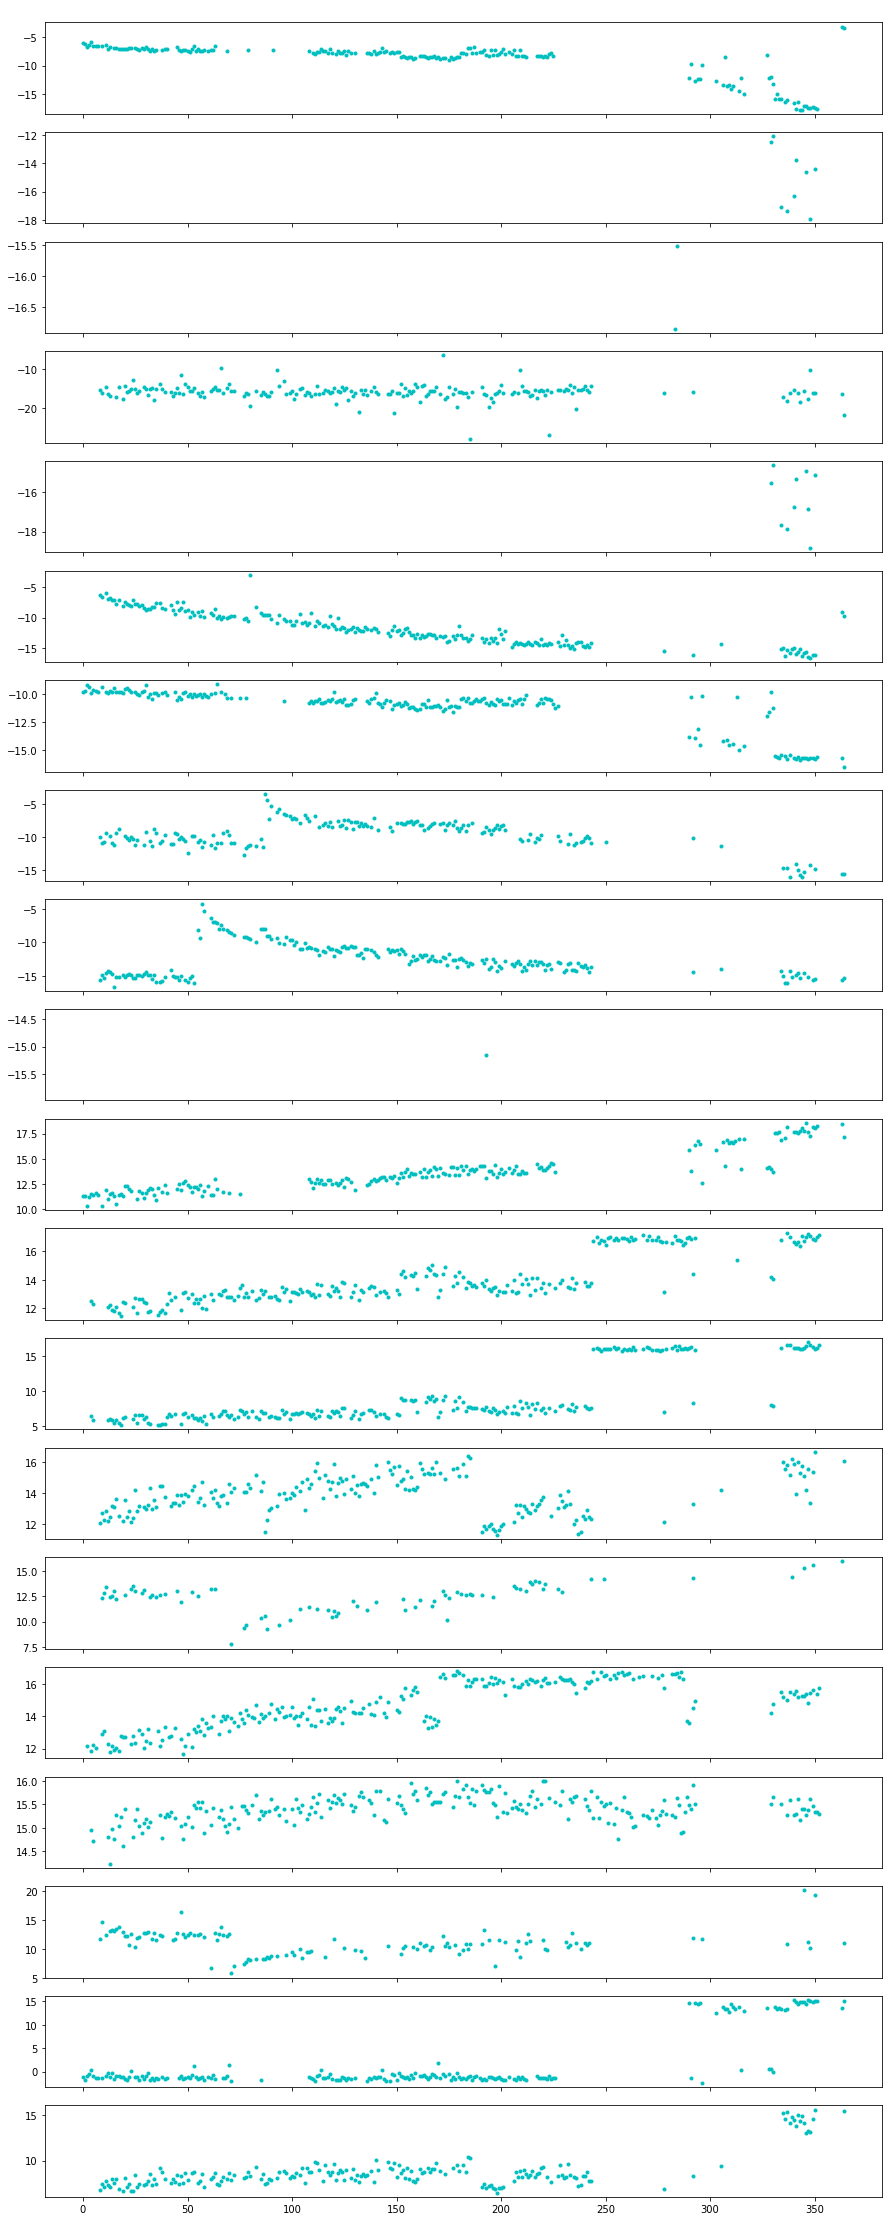

In [43]:
fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

for i, (no, kilo) in enumerate(zip(inter_df['路線'], inter_df['キロ程'])):
    track = tracks[no]
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左', '高低右', '水準']]
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    axes[i].set_title(f'no: {no},  kilo: {kilo},  intercept: {inter_df.iloc[i, 3]}', color='w')

In [45]:
submit['高低91'] = submit['切片'] + submit['傾き_best']*105

In [46]:
low = submit.sort_values('高低91').head(10)
high = submit.sort_values('高低91', ascending=False).head(10)
koutei91_df = pd.concat([low, high], axis=0)
koutei91_df

,路線,キロ程,傾き,切片,傾き_lgbm,傾き12右,傾き12右_lgbm,傾き4左,傾き4左_lgbm,傾き4右,傾き4右_lgbm,傾き5左,傾き5左_lgbm,傾き5右,傾き5右_lgbm,傾き_best,高低91
70976,C,31539,-0.005009,-17.320,-0.002238,-0.012113,-0.007406,-0.005874,-0.001996,-0.010705,-0.005848,-0.004993,-0.000476,-0.018634,-0.013400,-0.013400,-18.727021
112301,D,17180,-0.025171,-15.790,-0.022309,-0.016207,-0.015274,-0.028388,-0.027096,-0.018098,-0.015940,-0.009162,-0.014349,-0.016953,-0.015639,-0.022309,-18.132460
12981,A,22981,-0.020933,-14.810,-0.018965,-0.006724,-0.007068,-0.022060,-0.020097,-0.006200,-0.006077,-0.017095,-0.015480,-0.005817,-0.006608,-0.020097,-16.920148
29539,B,11633,0.000062,-16.705,0.000367,0.000057,-0.000204,0.000066,0.000149,0.000055,-0.000073,0.000093,0.000251,0.000095,0.000272,0.000367,-16.666425
109652,D,14531,-0.008357,-15.270,-0.003829,-0.005198,-0.003331,-0.004381,-0.001297,-0.007775,-0.003679,-0.009243,-0.001615,-0.004842,-0.002893,-0.009243,-16.240563
36819,B,18913,0.000062,-16.185,0.000058,0.000057,0.000037,0.000066,0.000050,0.000055,0.000069,0.000093,0.000100,0.000095,0.000058,0.000062,-16.178459
108839,D,13718,-0.001364,-16.160,-0.002121,0.000385,-0.002025,0.000051,-0.001994,0.000069,-0.002281,0.001199,0.000288,-0.000184,0.001413,0.001199,-16.034110
29538,B,11632,0.000062,-16.020,0.000209,0.000057,-0.000218,0.000066,-0.000029,0.000055,0.000149,0.000093,0.000297,0.000095,-0.000142,0.000297,-15.988819
86057,C,46620,-0.001099,-15.710,-0.002898,0.000788,-0.001927,-0.008298,-0.003604,-0.005196,-0.002762,-0.007978,-0.002055,-0.003637,-0.002133,-0.002133,-15.933970
111493,D,16372,-0.017787,-15.260,-0.007728,-0.006151,-0.006839,-0.017348,-0.019645,-0.007734,-0.005511,-0.014400,-0.007111,-0.005192,-0.004112,-0.006151,-15.905829


Text(0.5, 1.0, 'no: C,  kilo: 31539,  koutei91: -18.727021124931312')

Text(0.5, 1.0, 'no: D,  kilo: 17180,  koutei91: -18.13246042976838')

Text(0.5, 1.0, 'no: A,  kilo: 22981,  koutei91: -16.9201475005366')

Text(0.5, 1.0, 'no: B,  kilo: 11633,  koutei91: -16.666425354022348')

Text(0.5, 1.0, 'no: D,  kilo: 14531,  koutei91: -16.240563013840738')

Text(0.5, 1.0, 'no: B,  kilo: 18913,  koutei91: -16.17845872087205')

Text(0.5, 1.0, 'no: D,  kilo: 13718,  koutei91: -16.03411032605834')

Text(0.5, 1.0, 'no: B,  kilo: 11632,  koutei91: -15.988819399719977')

Text(0.5, 1.0, 'no: C,  kilo: 46620,  koutei91: -15.933970417874091')

Text(0.5, 1.0, 'no: D,  kilo: 16372,  koutei91: -15.905828688458067')

Text(0.5, 1.0, 'no: C,  kilo: 10547,  koutei91: 18.449255038963415')

Text(0.5, 1.0, 'no: D,  kilo: 14504,  koutei91: 17.158031472371853')

Text(0.5, 1.0, 'no: B,  kilo: 15181,  koutei91: 17.112632310141695')

Text(0.5, 1.0, 'no: D,  kilo: 18740,  koutei91: 16.78462455274428')

Text(0.5, 1.0, 'no: B,  kilo: 15180,  koutei91: 16.444905646697606')

Text(0.5, 1.0, 'no: B,  kilo: 10360,  koutei91: 15.93928156238212')

Text(0.5, 1.0, 'no: B,  kilo: 17843,  koutei91: 15.426916598699197')

Text(0.5, 1.0, 'no: C,  kilo: 21181,  koutei91: 15.39962519371575')

Text(0.5, 1.0, 'no: D,  kilo: 19038,  koutei91: 15.295')

Text(0.5, 1.0, 'no: A,  kilo: 23173,  koutei91: 15.167777299403378')

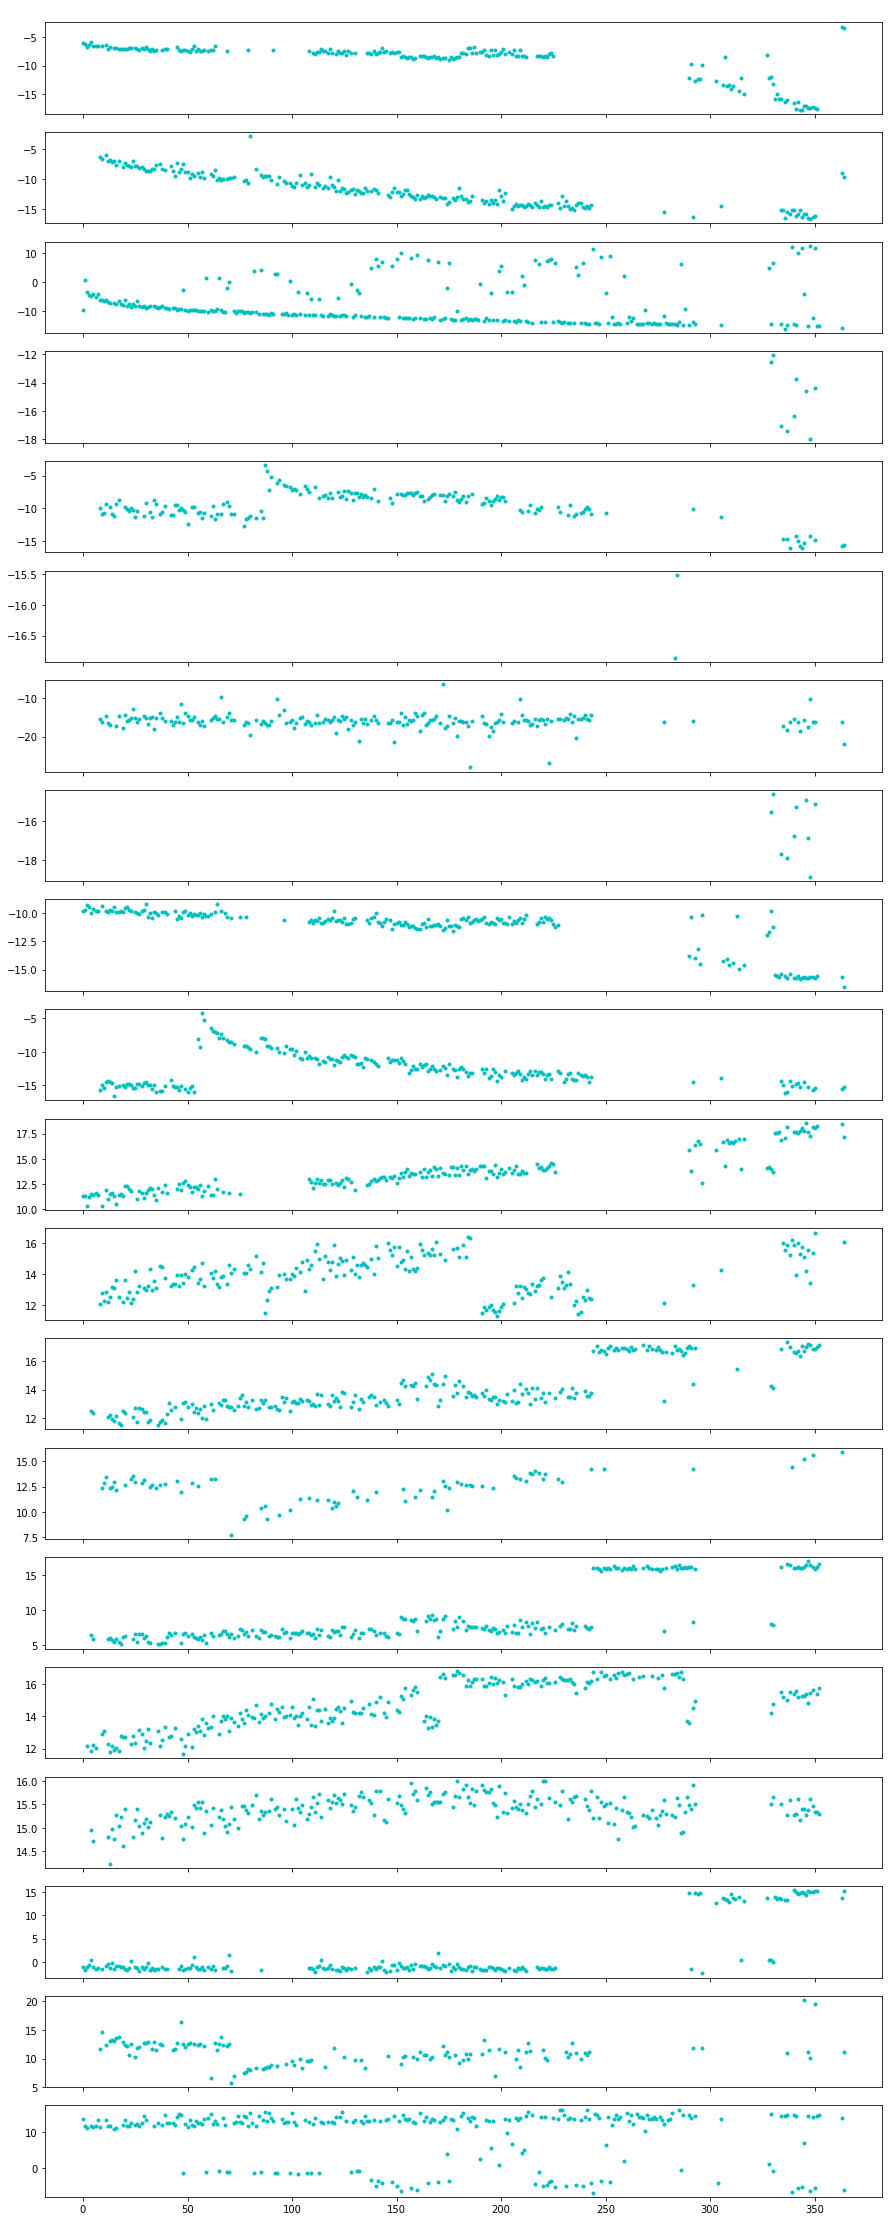

In [49]:
fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

for i, (no, kilo) in enumerate(zip(koutei91_df['路線'], koutei91_df['キロ程'])):
    track = tracks[no]
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左', '高低右', '水準']]
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    axes[i].set_title(f'no: {no},  kilo: {kilo},  koutei91: {koutei91_df.iloc[i, -1]}', color='w')

In [53]:
submision = pd.read_csv(f'submit21.csv', index_col=0, header=None)

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [71]:
len_A = len(summarys['A'])
# submision[:len_A]
len_A
# submision[:len_A].values == submision[len_A*90:len_A*91].values
sum(submision[:len_A].values == submision[len_A*90:len_A*91].values)

27906

array([5177])

In [72]:
len_B = len(summarys['B'])
len_B
sum(submision[len_A*91:len_A*91+len_B].values == submision[len_A*91+len_B*90:len_A*91+len_B*91].values)

21531

array([4094])

In [73]:
len_C = len(summarys['C'])
len_C
sum(submision[len_A*91+len_B*91:len_A*91+len_B*91+len_C].values == submision[len_A*91+len_B*91+len_C*90:len_A*91+len_B*91+len_C*91].values)

55684

array([18484])

In [77]:
len_D = len(summarys['D'])
len_D
sum(submision[len_A*91+len_B*91+len_C*91:len_A*91+len_B*91+len_C*91+len_D].values == submision[len_A*91+len_B*91+len_C*91+len_D*90:len_A*91+len_B*91+len_C*91+len_D*91].values)

15691

array([2322])